In [2]:
from matplotlib import pyplot as plt
import platform, os, sys, pprint, h5py
from tqdm import tqdm, trange
import numpy as np
from glob import glob
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from mpl_toolkits.axes_grid.inset_locator import inset_axes

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\Gerwin\Documents\Code')
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal
from glob import glob 
from pprint import pprint
from mpltools import color

%matplotlib inline
# %config InlineBackend.figure_format='retina'

In [3]:
try:
    import qutip
except:
    print("Warning no qutip!")
from matplotlib.pyplot import *
import numpy as np

from scipy import sparse
from scipy.sparse.linalg import eigsh
from numpy import pi, linspace, cos, sin, ones, transpose, reshape, array, argsort, sort, \
    meshgrid, amax, amin, dot, sqrt, exp, tanh, sign, argmax
from numpy.linalg import eig


class Schrodinger:
    """Abstract class for solving the 1D and 2D Schrodinger equation 
    using finite differences and sparse matrices"""

    def __init__(self, sparse_args=None, solve=True):
        """ @param sparse_args arguments for the eigsh sparse solver
            @param solve if solve=True then it will immediately construct the Hamiltonian and solve for the eigenvalues
        """
        self.solved = False
        self.sparse_args = sparse_args
        self.solved = False
        if solve: self.solve()

    @staticmethod
    def uv(vec):
        """normalizes a vector
            @param vec vector to normalize
        """
        return vec / sqrt(dot(vec, vec))

    @staticmethod
    def Dmat(numpts, delta=1):
        """Derivative matrix
            @param numpts dimension of derivative matrix
            @param delta optional scaling of point spacing
        """
        a = 0.5 / delta * ones(numpts)
        a[0] = 0
        a[-2] = 0
        #b=-2./delta**2*ones(numpts); b[0]=0;b[-1]=0
        c = -0.5 / delta * ones(numpts)
        c[1] = 0
        c[-1] = 0
        return sparse.spdiags([a, c], [-1, 1], numpts, numpts)

    @staticmethod
    def D2mat(numpts, delta=1, periodic=True, q=0):
        """2nd Derivative matrix
            @param numpts dimension of derivative matrix
            @param delta spacing between points
            @param periodic whether derivative wraps around (default True) 
            @param q is a quasimomentum between -pi and pi, which is used if periodic=True
        """

        a = 1. / delta ** 2 * ones(numpts)
        b = -2. / delta ** 2 * ones(numpts)
        c = 1. / delta ** 2 * ones(numpts)
        #print "delta = %f" % (delta)
        if periodic:
            if q == 0:
                return sparse.spdiags([c, a, b, c, c], [-numpts + 1, -1, 0, 1, numpts - 1], numpts, numpts)
            else:
                return sparse.spdiags([exp(-(0. + 1.j) * q) * c, a, b, c, exp((0. + 1.j) * q) * c],
                                      [-numpts + 1, -1, 0, 1, numpts - 1], numpts, numpts)
        else:
            return sparse.spdiags([a, b, c], [-1, 0, 1], numpts, numpts)

    def Hamiltonian(self):
        """Abstract method used by solver"""
        return None

    def solve(self, sparse_args=None):
        """Constructs and solves for eigenvalues and eigenvectors of Hamiltonian
            @param sparse_args if present used in eigsh sparse solver"""
        Hmat = self.Hamiltonian()
        if sparse_args is not None: self.sparse_args = sparse_args
        if self.sparse_args is None:
            en, ev = eig(Hmat.todense())
        else:
            en, ev = eigsh(Hmat, **self.sparse_args)
        ev = transpose(array(ev))[argsort(en)]
        en = sort(en)
        self.en = en
        self.ev = ev
        self.solved = True
        return self.en, self.ev

    def energies(self, num_levels=-1):
        """returns eigenvalues of Hamiltonian (solves if not already solved)"""
        if not self.solved: self.solve()
        return self.en[:num_levels]

    def psis(self, num_levels=-1):
        """returns eigenvectors of Hamiltonian (solves if not already solved)"""
        if not self.solved: self.solve()
        return self.ev[:num_levels]

    def reduced_operator(self, operator, num_levels=-1):
        """Finds operator in eigenbasis of the hamiltonian truncated to num_levels
        @param operator a (sparse) matrix representing an operator in the x basis
        @num_levels number of levels to truncate Hilbert space
        """
        if not self.solved: self.solve()
        if sparse.issparse(operator):
            return array([array([dot(psi1, operator.dot(psi2)) for psi2 in self.psis(num_levels)]) for psi1 in
                          self.psis(num_levels)])
        else:
            return array([array([dot(psi1, dot(operator, psi2)) for psi2 in self.psis(num_levels)]) for psi1 in
                          self.psis(num_levels)])

class Schrodinger2D(Schrodinger):
    def __init__(self, x, y, U, KEx=1, KEy=1, periodic_x=False, periodic_y=False, qx=0, qy=0, sparse_args=None,
                 solve=True):
        """@param x is array of locations in x direction
           @param y is array of locations in y direction
           @param U is array of potential at x
           @param KEx is kinetic energy prefactor in x direction
           @param KEy is kinetic energy prefactor in y direction
           @param periodic_x True/False for x boundary conditions
           @param periodic_y True/False for y boundary conditions
           @param qx, if periodic_x=True then use exp(i qx) for boundary condition phase
           @param qy, if periodic_y=True then use exp(i qy) for boundary condition phase
           @param num_levels (None)...number of levels for sparse solver or None for dense solve...sparse not working right yet...+
        """
        self.x = x
        self.y = y
        self.U = U
        self.KEx = KEx
        self.KEy = KEy
        self.qx = qx
        self.qy = qy
        self.periodic_x = periodic_x
        self.periodic_y = periodic_y
        Schrodinger.__init__(self, sparse_args=sparse_args, solve=solve)

    def Hamiltonian(self):
        """Constructs Hamiltonian using the potential and Kinetic energy terms"""
        U = self.U.flatten()
        Vmat = sparse.spdiags([U], [0], len(U), len(U))
        Kmat = sparse.kron(-self.KEy * Schrodinger.D2mat(len(self.y), self.y[1] - self.y[0], self.periodic_y, self.qy),
                           sparse.identity(len(self.x))) + \
               sparse.kron(sparse.identity(len(self.y)),
                           -self.KEx * Schrodinger.D2mat(len(self.x), self.x[1] - self.x[0], self.periodic_x, self.qx))
        return Kmat + Vmat

    def get_2Dpsis(self, num_levels=-1):
        psis = []
        for psi in self.psis(num_levels):
            psis.append(reshape(psi, (len(self.y), len(self.x))))
        return psis

    def plot(self, num_levels=10):
        """Plots potential, energies, and wavefunctions
        @param num_levels (-1 by default) number of levels to plot"""
        if num_levels == -1:
            num_levels = len(self.energies())
        print(self.energies(num_levels))
        figure(figsize=(20, 5))
        subplot(1, num_levels + 1, 1)
        self.plot_potential()
        #xlabel('$\phi$')
        for ii, psi2D in enumerate(self.get_2Dpsis(num_levels)):
            subplot(1, num_levels + 1, ii + 2)
            #imshow(psi2D.real,extent=(self.x[0],self.x[-1],self.y[0],self.y[-1]),interpolation="None",aspect='auto')
            imshow(psi2D.real, interpolation="None", aspect='auto')
            xlabel(ii)

    def plot_potential(self):
        """Plots potential energy landscape"""
        imshow(self.U, extent=(self.x[0], self.x[-1], self.y[0], self.y[-1]), aspect='auto', interpolation='None')
        xlabel('x')
        ylabel('y')

Warning no qutip!


# Load electrostatic potential from simulation data 

In [4]:
from TrapAnalysis.solve_eom import FullSolver
from scipy.constants import hbar, m_e, elementary_charge as q_e

settings_file = r"S:\Gerwin\Electron on helium\Maxwell\M018 Yggdrasil\M018V6"
settings_file += r"\With L3 etch - just trap\settings.json"
fs = FullSolver(settings_file)

x = 0.15

mu_guess = -0.265
def f_mu(mu):
    return -1.755 - 7*mu

Vtrap = np.linspace(0.20, 0.40, 61) 
Vrg = np.linspace(-1/1.15 * (Vtrap[0] - (f_mu(mu_guess)-0.120)) - x, 
                  -1/1.15 * (Vtrap[-1] -(f_mu(mu_guess)-0.120)), len(Vtrap))
Vres = 0.60 * np.ones(len(Vtrap)) 
Vtg = 0.00 * np.ones(len(Vtrap))
Vcg = None

# N_e = 3

# electron_positions = fs.get_trap_electron_positions(Vres, Vtrap, Vrg, Vtg, N=N_e)
# tex = electron_positions[:, ::2]
# tey = electron_positions[:, 1::2]

In [5]:
fs.set_dc_interpolator(0.60, 0.30, -0.30, 0.00)

In [6]:
Npts = 501

x = np.linspace(-1.5E-6, 1.5E-6, Npts)
y = np.linspace(-3E-6, 3E-6, Npts)

X, Y = np.meshgrid(x, y)

U = fs.dc_interpolator.ev(X, Y)
min_idx = np.unravel_index(np.argmin(U), np.shape(U))

print("Interpolation spacing in (x, y) direction is (%.0f nm, %.0f nm)" % (np.diff(x)[0] * 1E9, np.diff(y)[0] * 1E9))

Interpolation spacing in (x, y) direction is (6 nm, 12 nm)


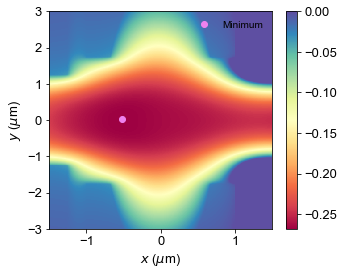

In [7]:
fig = plt.figure(figsize=(5, 4.))
common.configure_axes(13)
plt.pcolormesh(X * 1E6, Y * 1E6, U, cmap=plt.cm.Spectral, vmin=np.min(U), vmax=0.0)
plt.plot(X[min_idx] * 1E6, Y[min_idx] * 1E6, 'o', color='violet', label="Minimum")
plt.legend(loc=0, frameon=False, prop={"size" : 10})
plt.colorbar()
plt.ylabel("$y$ ($\mu$m)")
plt.xlabel("$x$ ($\mu$m)")

The Schrodinger equation is as follows: 
$$ \left( \frac{\hbar^2}{2m_e} \nabla^2 + V \right) \psi = E \psi $$
We can rewrite $V = e \phi$ and then work in units of eV by dividing the entire equation by $e$. This leads to 
$$ \left( \frac{\hbar^2}{2 e m_e} \nabla^2 + \phi \right) \psi = \frac{E}{e} \psi $$
$\phi$ is the electrostatic potential that we get you can get from simulation. It's positive when you apply a positive voltage on one of the electrodes. Let us know write the equation such that the kinetic terms are 1: 
$$ \left( \nabla^2 + \frac{2 e m_e}{\hbar^2} \phi \right) \psi = \frac{2 m_e e}{\hbar^2} \frac{E}{e} \psi $$

In [8]:
class SingleElectron(Schrodinger2D):
    def __init__(self, x, y, potential_function, sparse_args=None, solve=True):
        """
        https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/generated/scipy.sparse.linalg.eigsh.html
        potential_function: a function that takes as arguments a meshgrid of x, y coordinates. For a positive voltage on the 
        electrodes, this function is negative!
        """
        self.x = x
        self.y = y
        
        self.numxpts = len(x)
        self.numypts = len(y)
        
        self.potential = potential_function
               
        Vxy = self.evaluate_potential(self.x, self.y)
        Schrodinger2D.__init__(self, x=self.x, y=self.y, U=Vxy, KEx=1, KEy=1, 
                               periodic_x=False, periodic_y=False, qx=0, qy=0, 
                               sparse_args=sparse_args, solve=solve)
    
    def evaluate_potential(self, x, y):
        X, Y = np.meshgrid(x, y)
        return + 2 * m_e * q_e * self.potential(X, Y) / hbar ** 2

    def sparsify(self, num_levels=10):
        self.U = self.evaluate_potential(self.x, self.y)
        self.sparse_args = {'k': num_levels, # Find k eigenvalues and eigenvectors
                            'which': 'LM', # ‘LM’ : Largest (in magnitude) eigenvalues
                            'sigma': np.min(self.U), # 'sigma' : Find eigenvalues near sigma using shift-invert mode.
                            'maxiter': None} # Maximum number of Arnoldi update iterations allowed Default: n*10

To find the proper ground state, the solver needs a guess. For this guess, we choose the potential minimum. Below is the value that is programmed in the code

In [9]:
print("The potential minimum is %.6f eV" % (np.min(U) * hbar ** 2 / (2 * q_e * m_e) ))

NameError: name 'el' is not defined

Now let's solve the sparse system of equations. To get the mode frequencies, remember that the eigenvalues are given as
$$ E' = \frac{2 m_e e}{\hbar^2} \frac{E}{e} $$
Therefore, to get the eigenfrequency $f = E/h$ we have to apply the following multiplicative factors:
$$ f = \frac{E}{h} = \frac{e \hbar^2 E'}{2 e m_e h}$$

In [10]:
N_evals = 10

el = SingleElectron(x, y, potential_function=fs.dc_interpolator.ev, solve=False)
el.sparsify(num_levels=N_evals)
Evals, Evecs = el.solve(sparse_args=el.sparse_args)

Psis = el.get_2Dpsis(N_evals)
mode_frequencies = (Evals - Evals[0]) * hbar**2 / (2 * q_e * m_e) * q_e / (2 * np.pi * hbar)

In [11]:
print(tabulate(np.array([np.arange(N_evals), (mode_frequencies)/1E9, 
                np.append(np.zeros(1), np.diff(mode_frequencies)/1E9), 
                         [np.sum(Psis[i] * np.conjugate(Psis[i])) for i in range(N_evals)]]).T, 
               tablefmt="fancy_grid", headers=["n", "fn (GHz)", "fn - fn-1 (GHz)", "||<n|n>||"], 
               floatfmt=".3f", numalign="center", stralign='left'))

╒═══════╤════════════╤═══════════════════╤═════════════╕
│   n   │  fn (GHz)  │  fn - fn-1 (GHz)  │  ||<n|n>||  │
╞═══════╪════════════╪═══════════════════╪═════════════╡
│ 0.000 │   0.000    │       0.000       │    1.000    │
├───────┼────────────┼───────────────────┼─────────────┤
│ 1.000 │   5.804    │       5.804       │    1.000    │
├───────┼────────────┼───────────────────┼─────────────┤
│ 2.000 │   12.651   │       6.846       │    1.000    │
├───────┼────────────┼───────────────────┼─────────────┤
│ 3.000 │   14.760   │       2.109       │    1.000    │
├───────┼────────────┼───────────────────┼─────────────┤
│ 4.000 │   19.491   │       4.731       │    1.000    │
├───────┼────────────┼───────────────────┼─────────────┤
│ 5.000 │   21.055   │       1.565       │    1.000    │
├───────┼────────────┼───────────────────┼─────────────┤
│ 6.000 │   26.288   │       5.233       │    1.000    │
├───────┼────────────┼───────────────────┼─────────────┤
│ 7.000 │   27.990   │       1.

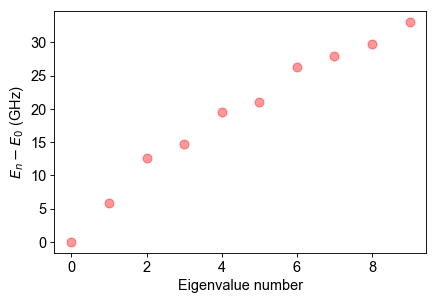

In [12]:
# plt.figure()
# plot((Evals * hbar**2 / (2 * q_e * m_e) - U[min_idx]) * 1E6, 'o', **common.plot_opt('red'))
# plt.xlabel("Eigenvalue number")
# plt.ylabel("$E_n - e\phi(x_\min, y_\min)$ ($\mu$eV)")

plt.figure()
plot(mode_frequencies / 1E9, 'o', **common.plot_opt('red'))
plt.xlabel("Eigenvalue number")
plt.ylabel("$E_n - E_0$ (GHz)")

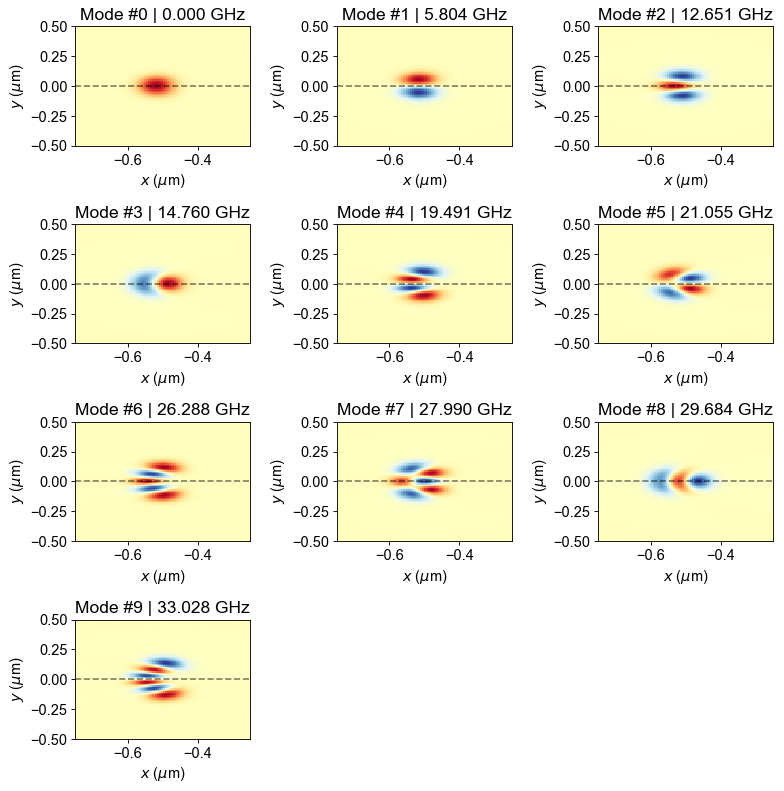

In [13]:
fig = plt.figure(figsize=(10., 12.))

for i in range(N_evals):
    max_idx = np.unravel_index(np.argmax(Psis[i]), np.shape(U))
    cmax = np.max(np.abs(Psis[i]))
    cmin = -cmax
    
    plt.subplot(5, 3, i+1)
    plt.pcolormesh(el.x * 1E6, el.y * 1E6, Psis[i], cmap=plt.cm.RdYlBu_r, vmin=cmin, vmax=cmax)
    if 0:
        plt.plot(X[min_idx] * 1E6, Y[min_idx] * 1E6, 'o', color='black', label="Classical minimum")
        plt.legend(loc=0, prop={"size" : 10}, frameon=False)
    
    plt.title("Mode #%d | %.3f GHz" % (i, (mode_frequencies[i] - mode_frequencies[0])/1E9))
    plt.hlines(0.0, -0.75, -0.25, linestyles='--', color='k', alpha=0.5)
    plt.xlabel("$x$ ($\mu$m)")
    plt.ylabel("$y$ ($\mu$m)")
    plt.xlim(-0.75, -0.25)
    plt.ylim(-0.5, 0.5)
#     plt.colorbar()

fig.tight_layout()
# plt.show()

## Plot a 1D slice

(-0.25, -0.24)

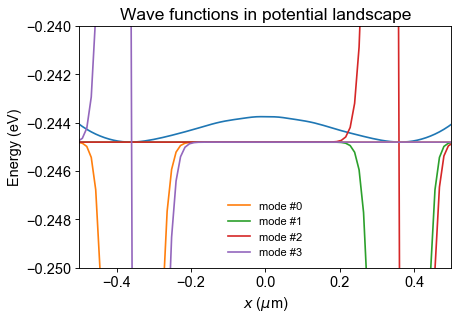

In [128]:
xoi = -0.50 * 1E-6
xoi_idx = common.find_nearest(el.x, xoi)
potential1D = fs.dc_interpolator.ev(xoi, el.y)

plt.plot(el.y * 1E6, potential1D)
for i in range(4):
    plt.plot(el.y * 1E6, Psis[i][:, xoi_idx] + np.min(potential1D), label="mode #%d"%i)

plt.legend(loc=0, frameon=False, prop={"size" : 10})
plt.xlim(-0.5, 0.5)
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("Energy (eV)")
plt.title("Wave functions in potential landscape")
plt.ylim(-0.25, -0.24)

# Calculate the coupling of all modes

## Load RF data

In [121]:
fs.set_rf_interpolator()

In [122]:
mode_contours = [0.01, 0.05, 0.10]
mode_number = 1

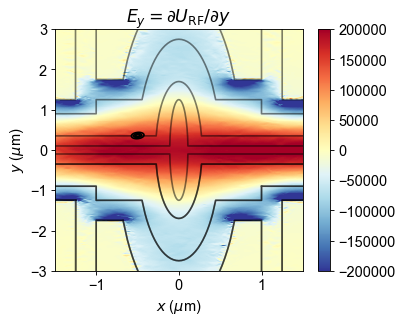

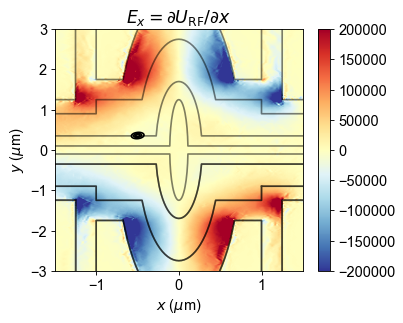

In [123]:
fig = plt.figure(figsize=(5, 4.))
plt.pcolormesh(el.x * 1E6, el.y * 1E6, fs.Ey(X, Y), cmap=plt.cm.RdYlBu_r, vmin=-2E5, vmax=2E5)
plt.colorbar()

# CS = plt.contour(Vresguards, Vtraps-0.120, Em, colors='white', levels=levels)
# plt.clabel(CS, colors='white', inline=1, fontsize=10)
anneal.draw_from_dxf(os.path.join(fs.master_path, "all_electrodes.dxf"), offset=(0E-6, 0E-6),
                                 color="k", alpha=0.5)

CS = plt.contour(el.x * 1E6, el.y * 1E6, np.abs(Psis[mode_number]), colors='black', levels=mode_contours, lw=0.5)

plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
plt.title("$E_y = \partial U_\mathrm{RF}/\partial y$")
plt.xlim(np.min(x) * 1E6, np.max(x) * 1E6)
plt.ylim(np.min(y) * 1E6, np.max(y) * 1E6)

fig = plt.figure(figsize=(5, 4.))
plt.pcolormesh(el.x * 1E6, el.y * 1E6, fs.Ex(X, Y), cmap=plt.cm.RdYlBu_r, vmin=-2E5, vmax=2E5)
plt.colorbar()
anneal.draw_from_dxf(os.path.join(fs.master_path, "all_electrodes.dxf"), offset=(0E-6, 0E-6),
                                 color="k", alpha=0.5)
plt.xlim(np.min(x) * 1E6, np.max(x) * 1E6)
plt.ylim(np.min(y) * 1E6, np.max(y) * 1E6)

CS = plt.contour(el.x * 1E6, el.y * 1E6, np.abs(Psis[mode_number]), colors='black', levels=mode_contours, lw=0.5)

plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
plt.title("$E_x = \partial U_\mathrm{RF}/\partial x$")

## Calculate $g_{ij}$ and transition dipole moment

The coupling matrix tells us something about how strongly a specific transition couples to the resonator mode. It's given by 
$$ g_{ij} = \langle \psi_i | \mathbf{d} \cdot \mathbf{E} | \psi_j \rangle = e \sqrt{\frac{\hbar \omega_0^2 Z_0}{2}} \iint \psi_i (x,y) (x E_x + y E_y) \psi_j^* (x,y) dx dy $$
where $E_{x,y}$ are the electric fields in the $x,y$ direction determined from electrostatic simulation where $\pm0.5$V was applied to the resonator pins. The prefactor turns that into a single photon coupling.

In [124]:
omega0 = 2 * np.pi * 6.5E9
Z0 = 100

gij = np.zeros((N_evals, N_evals))
rij = np.zeros((N_evals, N_evals))

prefactor = q_e * np.sqrt(hbar * omega0**2 * Z0 / 2) * 1 / (2 * np.pi * hbar)

for i in trange(N_evals):
    for j in range(N_evals):
        gij[i, j] = prefactor * np.sum(Psis[i] * ( X * fs.Ex(X, Y) + Y * fs.Ey(X, Y) ) * np.conjugate(Psis[j]))
        rij[i, j] = np.sum(Psis[i] * Y * np.conjugate(Psis[j]))

100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


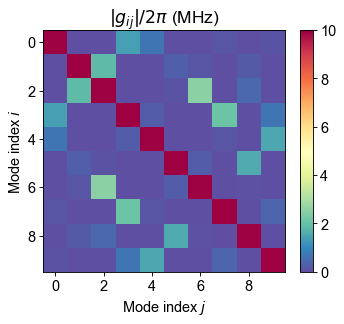

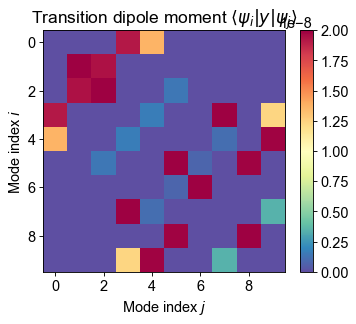

In [126]:
fig = plt.figure(figsize=(5, 4.))
common.configure_axes(13)
plt.imshow(np.abs(gij)/1E6, cmap=plt.cm.Spectral_r)
plt.xlabel("Mode index $j$")
plt.ylabel("Mode index $i$")
plt.title("$|g_{ij}|/2\pi$ (MHz)")
plt.clim(0, 10)
plt.colorbar()

fig = plt.figure(figsize=(5, 4.))
common.configure_axes(13)
plt.imshow(rij, cmap=plt.cm.Spectral_r)
plt.xlabel("Mode index $j$")
plt.ylabel("Mode index $i$")
plt.title(r"Transition dipole moment $\langle \psi_i | y | \psi_j \rangle $")
plt.colorbar()
plt.clim(0, 0.2E-7)

# Dependence on potential spacing

In [66]:
mode_frequency_dependency = list()
evaluation_points = np.arange(101, 801, 50)

for Npts in evaluation_points:

    x = np.linspace(-1.5E-6, 1.5E-6, Npts)
    y = np.linspace(-3E-6, 3E-6, Npts)

    X, Y = np.meshgrid(x, y)

    U = fs.dc_interpolator.ev(X, Y)
    min_idx = np.unravel_index(np.argmin(U), np.shape(U))

    print("Interpolation spacing in (x, y) direction is (%.0f nm, %.0f nm)" % (np.diff(x)[0] * 1E9, np.diff(y)[0] * 1E9))
    
    N_evals = 10

    el = SingleElectron(x, y, potential_function=fs.dc_interpolator.ev, solve=False)
    el.sparsify(num_levels=N_evals)
    Evals, Evecs = el.solve(sparse_args=el.sparse_args)

    Psis = el.get_2Dpsis(N_evals)
    mode_frequency_dependency.append((Evals - Evals[0]) * hbar**2 / (2 * q_e * m_e) * q_e / (2 * np.pi * hbar))
    
mode_frequency_dependency = np.array(mode_frequency_dependency)

Interpolation spacing in (x, y) direction is (30 nm, 60 nm)
Interpolation spacing in (x, y) direction is (20 nm, 40 nm)
Interpolation spacing in (x, y) direction is (15 nm, 30 nm)
Interpolation spacing in (x, y) direction is (12 nm, 24 nm)
Interpolation spacing in (x, y) direction is (10 nm, 20 nm)
Interpolation spacing in (x, y) direction is (9 nm, 17 nm)
Interpolation spacing in (x, y) direction is (7 nm, 15 nm)
Interpolation spacing in (x, y) direction is (7 nm, 13 nm)
Interpolation spacing in (x, y) direction is (6 nm, 12 nm)
Interpolation spacing in (x, y) direction is (5 nm, 11 nm)
Interpolation spacing in (x, y) direction is (5 nm, 10 nm)
Interpolation spacing in (x, y) direction is (5 nm, 9 nm)
Interpolation spacing in (x, y) direction is (4 nm, 9 nm)
Interpolation spacing in (x, y) direction is (4 nm, 8 nm)


(0.0, 13)

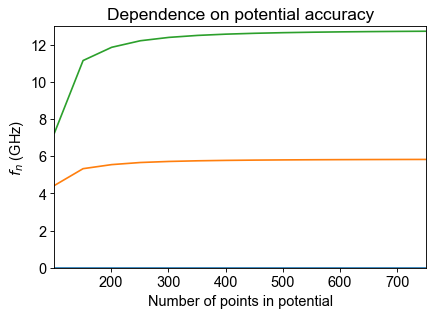

In [67]:
plt.plot(evaluation_points, mode_frequency_dependency/1e9)
plt.xlim(np.min(evaluation_points), np.max(evaluation_points))
plt.xlabel("Number of points in potential")
plt.ylabel("$f_n$ (GHz)")
plt.title("Dependence on potential accuracy")
plt.ylim(0., 13)

(0, 0.05)

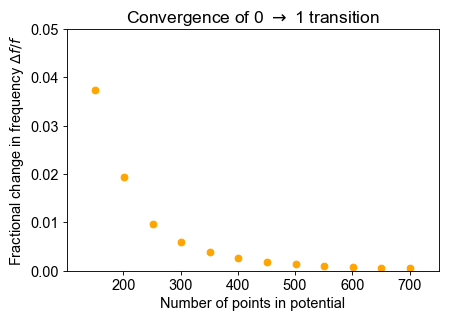

In [87]:
plt.plot(evaluation_points[:-1], np.abs(np.diff(mode_frequency_dependency[:,1]))/mode_frequency_dependency[-1, 1], 
         'o', color='orange')
# plt.plot(evaluation_points[:-1], np.abs(np.diff(mode_frequency_dependency[:,2]))/mode_frequency_dependency[-1, 2], 
#          'o', color='forestgreen')
plt.xlim(np.min(evaluation_points), np.max(evaluation_points))
plt.xlabel("Number of points in potential")
plt.ylabel("Fractional change in frequency $\Delta f/f$")
plt.title(r"Convergence of 0 $\rightarrow$ 1 transition")
plt.ylim(0, 0.05)
# plt.ylim(0., 13)

# Comparison with 2D harmonic oscillator potential

<img src="HarmonicOscillator2D.png"><img>

In [91]:
def psi00(x, y, alpha):
    return np.sqrt(alpha/np.pi) * np.e ** (-alpha/2. * (x**2 + y**2))

def psi10(x, y, alpha):
    return (4 * alpha**3 / np.pi) ** (1/4.) * (alpha/np.pi) ** (1/4.) * x * np.e ** (-alpha/2. * (x**2 + y**2))

def psi11(x, y, alpha):
    return np.sqrt(4 * alpha **3 / np.pi) * x * y * np.e ** (-alpha/2. * (x**2 + y**2))

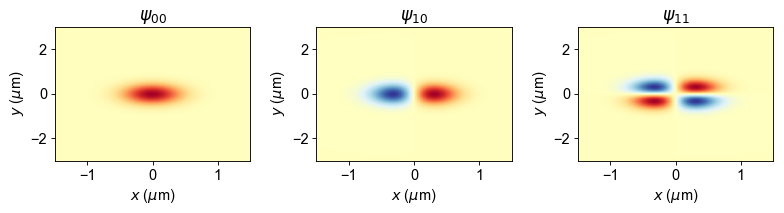

In [108]:
fig = plt.figure(figsize=(10., 12.))
wavefunctions = ["$\psi_{00}$", "$\psi_{10}$", "$\psi_{11}$"]
alpha = 1E13 # This is a proxy for the curvature
i = 0
for wf_str, wavefunction in zip(wavefunctions, [psi00, psi10, psi11]):
    
    cmax = np.max(np.abs(wavefunction(X, Y, alpha)))
    cmin = -cmax
    
    plt.subplot(5, 3, i+1)
    plt.pcolormesh(el.x * 1E6, el.y * 1E6, wavefunction(X, Y, alpha), cmap=plt.cm.RdYlBu_r, vmin=cmin, vmax=cmax)
    
    plt.title("%s" % wf_str)
    plt.xlabel("$x$ ($\mu$m)")
    plt.ylabel("$y$ ($\mu$m)")
#     plt.xlim(-0.75, -0.25)
#     plt.ylim(-0.25, 0.25)
#     plt.colorbar()
    i += 1

fig.tight_layout()